# Impact of conditional expectation pricing (Black-Scholes with Jump volatility)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.stats as st

In [2]:
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [3]:
def GeneratePaths(NoOfPaths, NoOfSteps, S0, T, muJ, sigmaJ, r):
    # Creat matrice for MC paths
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    S = np.zeros([NoOfPaths, NoOfSteps + 1])
    
    time = np.zeros([NoOfSteps + 1])
    
    dt = T / float(NoOfSteps)
    X[:, 0] = np.log(S0)
    S[:, 0] = S0
    
    Z = np.random.normal(0, 1, [NoOfPaths, NoOfSteps])
    J = np.random.normal(muJ, sigmaJ, [NoOfPaths, NoOfSteps])
    
    for i in range(0, NoOfSteps):
        # Making sure that samples from normal have mean 0 and variance t
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        
        X[:, i+1] = X[:, i] + (r - 0.5*J[:, i]**2)*dt + J[:, i]*np.sqrt(dt)*Z[:, i]
        time[i+1] = time[i] + dt
        
    S = np.exp(X)
    paths = {"time": time, "X": X, "S": S, "J": J}
    
    return paths
    
    

In [4]:
def EUOptionPriceFromMCPaths(CP, S, K, T, r):
    # S is a vector of Monte Carlo samples at T
    if CP == OptionType.CALL:
        return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))
    if CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K - S, 0))

In [5]:
def BS_Call_Put_Option_Price(CP, S_0, K, sigma, t, T, r):
    K = np.array(K).reshape([len(K), 1])
    
    d1 = (np.log(S_0/K) + (r + 0.5*np.power(sigma, 2))*(T - t)) / (sigma*np.sqrt(T -t))
    d2 = d1 - sigma*np.sqrt(T - t)
    
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r*(T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r*(T - t)) - st.norm.cdf(-d1) * S_0
        
    return value


In [6]:
def CallOption_CondExpectation(NoOfPaths, T, S0, K, J, r):
    # Jumps at time T
    J_i = J[:, -1]
    
    result = np.zeros([NoOfPaths])
    
    for j in range(0, NoOfPaths):
        sigma = J_i[j]
        result[j] = BS_Call_Put_Option_Price(OptionType.CALL, S0, [K], sigma, 0, T, r)
        
    return np.mean(result)


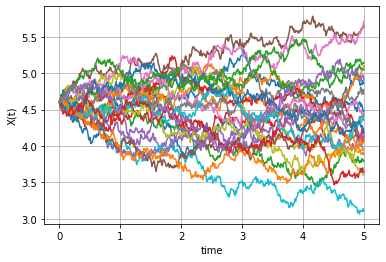

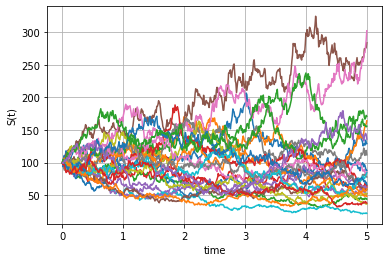

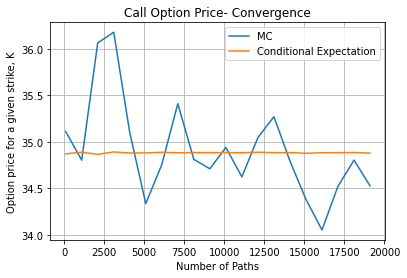

In [15]:
def mainCalculation():
    NoOfPaths = 25
    NoOfSteps = 500
    T = 5
    muJ = 0.3
    sigmaJ = 0.005
    
    S0 = 100
    r = 0
    Paths = GeneratePaths(NoOfPaths, NoOfSteps, S0, T, muJ, sigmaJ, r)
    timeGrid = Paths["time"]
    X = Paths["X"]
    S = Paths["S"]
    
    plt.figure(1)
    plt.plot(timeGrid, np.transpose(X))
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("X(t)")
    
    plt.figure(2)
    plt.plot(timeGrid, np.transpose(S))
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t)")
    
    # Check the convergence for a given strike
    K = 80
    CP = OptionType.CALL
    
    NGrid = range(100, 20000, 1000)
    NoOfRuns = len(NGrid)
    
    resultMC = np.zeros([NoOfRuns])
    resultCondExp = np.zeros([NoOfRuns])
    
    for (i, N) in enumerate(NGrid):
        #print(N)
        Paths = GeneratePaths(N, NoOfSteps, S0, T, muJ, sigmaJ, r)
        timeGrid = Paths["time"]
        S = Paths["S"]
        resultMC[i] = EUOptionPriceFromMCPaths(CP, S[:, -1], K, T, r)
        
        J = Paths["J"]
        resultCondExp[i] = CallOption_CondExpectation(N, T, S0, K, J, r)
    
    plt.figure(3)
    plt.plot(NGrid,resultMC)  
    plt.plot(NGrid,resultCondExp)
    plt.legend(['MC','Conditional Expectation'])
    plt.title('Call Option Price- Convergence')
    plt.xlabel('Number of Paths')
    plt.ylabel('Option price for a given strike, K')
    plt.grid()
    
mainCalculation()

The conditional expactation is very stable does not change so much, the MC path is fluctuate even high number of paths